In [3]:
# Importing dependencies
import numpy as np
# np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [4]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=0, mode='min')
callbacks_list = [earlystop]

In [5]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(1,input_shape = (X_train.shape[1],1),return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val),
                        verbose = 0, shuffle = False, callbacks=callbacks_list)
    # model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [6]:
# Evaluating the model
def evaluate_model(model,test,timesteps, sc):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test, verbose=0)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    Y_hat = np.array(Y_hat)
    Y_hat = sc.inverse_transform(Y_hat)
    Y_test = sc.inverse_transform(Y_test)
    print(Y_hat.shape, Y_test.shape)
    df2 = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_hat.flatten()})
    df2['actual_return'] = df2['Actual'].pct_change()
    # column predicted_return is (predicted - actual.shift(1))/actual.shift(1)
    df2['predicted_return'] = df2['Predicted'].pct_change()
    # column signal is 1 if predicted_return > 0 and actual_return > 0 or predicted_return < 0 and actual_return < 0
    df2['signal'] = np.where((df2['predicted_return'] > 0) & (df2['actual_return'] > 0) | (df2['predicted_return'] < 0) & (df2['actual_return'] < 0), 1, 0)
    # accuracy is the mean of the signal column
    accuracy = df2['signal'].mean()
    # construct a strategy, if predicted_return > 0, then I plus (actual.shift(-1) - actual), otherwise I minus (actual.shift(-1) - actual)
    df2['strategy'] = np.where(df2['predicted_return'] > 0, (df2['Actual'].shift(-1) - df2['Actual']), -(df2['Actual'].shift(-1) - df2['Actual']))
    # cumulative_strategy is the cumsum of column strategy
    cumulative_strategy = df2['strategy'].sum()
    return mse, rmse, r2, Y_test, Y_hat, accuracy, cumulative_strategy


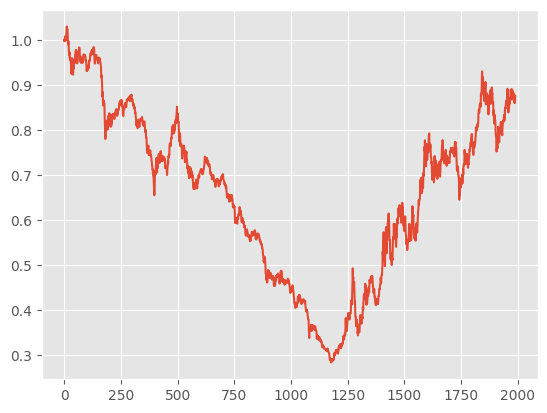

In [7]:
url = 'new2.csv'
df = pd.read_csv(url)
# df['close_price'].plot()
# Extracting the series
series = df['close_price']
# print(series.shape)
# series.plot()
series2 = series.values.reshape(-1,1)
train_data = series2[:int(0.7*len(series))]
val_data = series2[int(0.7*len(series)):int(0.85*len(series))]
test_data = series2[int(0.85*len(series)):]

# print(train_data.shape,val_data.shape,test_data.shape)

In [8]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
all_data = sc.transform(series2)
# print(train.shape,val.shape,test.shape)

In [9]:
timesteps = 40
hl = [40,35]
lr = 0.0005
batch_size = 64
num_epochs = 200

In [10]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
# plot_error(train_error,val_error)

/Users/ldvyyc/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
mse, rmse, r2_value,true,predicted, accuracy, cumu = evaluate_model(model,test,timesteps, sc)
print('RMSE = {}'.format(rmse))
print('MSE = {}'.format(rmse*rmse))
print('R-Squared Score = {}'.format(r2_value))
print('Accuracy = {}'.format(accuracy))
print('Cumulative Strategy = {}'.format(cumu))
# plot_data(true,predicted)

(259, 1) (259, 1)
RMSE = 0.2721967857125249
MSE = 0.07409109015223021
R-Squared Score = -8.529399999346545
Accuracy = 0.0
Cumulative Strategy = -0.14900411577526496
